In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import uproot
import awkward as ak
import tabulate as tab
import glob
import h5py
from tqdm import tqdm

from scipy.signal import find_peaks


# How to read raw data files

In [2]:
def read_root_files(filepath, cosmics=False):
    file = uproot.open(filepath)
    print(file.keys())
    analyszer = 'PNSCRPanalyzercosmics' if cosmics else 'PNSCRPanalyzerflashes1'
    evts = uproot.open(f"{filepath}:{analyszer}/Event")
    akw = evts.arrays(filter_name=evts.keys(), library="ak")
    return akw

def get_info(akw, display=False):
    Nevents    = len(akw['waveformsADC'])
    TrigWindow = len(akw['waveformsADC'][0][0])
    Nchannels  = len(akw['waveformsADC'][0])
    maxima = []
    for chID in range(0, Nchannels):
        maxima.append(ak.max( akw['waveformsADC'][:][chID]) )
    if display:
        print(' trigger reccords', Nevents)
        print(' trigger window', TrigWindow)
        print(' number of channels', Nchannels)
        print(' max height', int(np.max(maxima)) )
    return Nevents, TrigWindow, Nchannels, maxima


In [3]:
# path to the file
cernbox = '/Users/emiliebertholet/cernbox/coldbox_data'
directory = f'{cernbox}/anaCRP_files/raw_files'
filename = 'ana_pns_r25036_small_0_7.root'


In [4]:
cosmics = False
if 'cosmics' in filename: cosmics = True
akw = read_root_files(f'{directory}/{filename}', cosmics=cosmics)

['PNSCRPanalyzerflashes1;1', 'PNSCRPanalyzerflashes1/Event;87', 'PNSCRPanalyzerflashes1/Event;86']


In [5]:
_, _, _, _ = get_info(akw, display=True)

 trigger reccords 2324
 trigger window 65600
 number of channels 12
 max height 16383


In [6]:
akw

<Array [{event: 1, evttime: ..., ...}, ...] type='2324 * {event: int32, evt...'>

# File Organization

The file contains many variables corresponding to the readout of different detectors. For the moment, we focus on ```waveformsADC```, which stores the digitized output of the xARAPUCA modules (SiPM-based light detectors).

### Waveform Format

The waveforms are electrical pulses. Because they are digitized, they are recorded as ADC counts vs. time ticks, rather than voltage vs. physical time.

- 1 ADC count corresponds to a specific voltage increment.

- 1 time tick corresponds to a fixed time interval.

In the ColdBox there are several xARAPUCA modules. Each module provides 2 readout channels. At first, we want to look at 1 channel at a time.

The strucutre of the data for one specific channel is an array of arrays:

### Data Structure

For a given channel, the waveform data is stored as a list of arrays, where each array corresponds to one trigger record.

```
[
    [ADC_0, ADC_1, ADC_2, ..., ADC_N],   # trigger record 0
    [ADC_0, ADC_1, ADC_2, ..., ADC_N],   # trigger record 1
    ...
]

```

A trigger record correspond to an acquisition window of a fixed number of time ticks.






In [7]:
raw_wfs = akw['waveformsADC']
raw_wfs

<Array [[[1.7e+03, ..., 1.72e+03], ...], ...] type='2324 * var * var * float32'>

In [8]:
# select one trigger record from one channel
chID = 0
trigRec = 100
raw_wfs[trigRec][chID]

<Array [1.68e+03, 1.67e+03, ..., 1.65e+03, 1.66e+03] type='65600 * float32'>

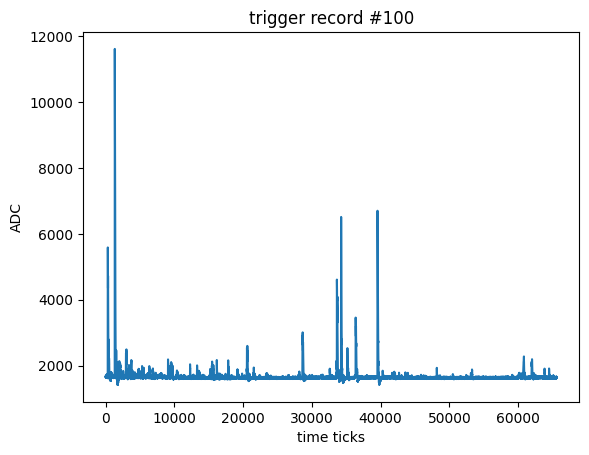

In [9]:
# one trigger record looks like that
chID = 0
trigRec =  100
plt.plot(raw_wfs[trigRec][chID])
plt.xlabel('time ticks')
plt.ylabel('ADC')
plt.title(f'trigger record #{trigRec}');

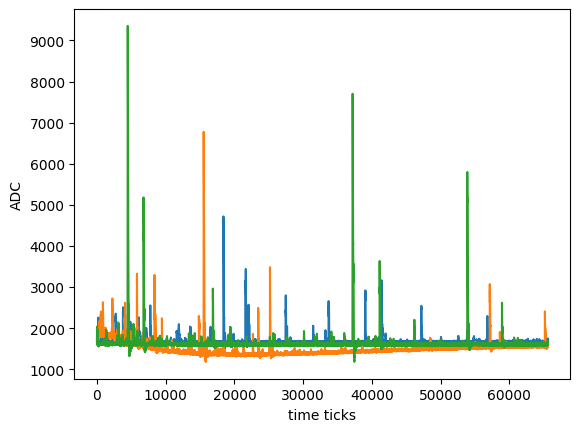

In [10]:
# several triggger records
triggerRecs = [0, 10, 15]
for i in triggerRecs:
    plt.plot(raw_wfs[i][chID])
plt.xlabel('time ticks')
plt.ylabel('ADC');

# Find peaks

Because the trigger window is relatively large, a single trigger record often contains multiple physical events. 

For our goal, we need to identify and extract these individual events from within each record. 

One way to do that is to search for peaks in the ADC waveform: each peak corresponds to a light pulse detected by the SiPM and therefore marks an event of interest.

In [11]:
def find_peaks_2d(array_trigRecxTT, **kwargs):
    """
    Find peaks in a 2D waveform array (trigRec x tt).
    
    Args:
        array_2d: np.ndarray shape (N_trigRecs, N_tt)
        kwargs: arguments for `scipy.signal.find_peaks`, e.g. height, distance, width

    Returns:
        dict with:
            - 'peak_indices': list of np.arrays with peak positions
            - 'peak_heights': list of np.arrays with peak heights
            - 'properties': list of full peak properties per waveform
            - 'pulses': list of slices around peaks (if width info available)
    """
    props_list = []
    peak_indices = []
    peak_heights = []
    peak_slices = []

    for row_idx, row in enumerate(array_trigRecxTT):
        peaks, props = find_peaks(row, **kwargs)

        # getters
        heights  = props.get("peak_heights", row[peaks])
        # left_ips = props.get("left_ips", props)

        # Extract waveform slices around peaks (if widths are calculated)
        slices = []
        if "left_ips" in props and "right_ips" in props:
            for l, r in zip(props["left_ips"], props["right_ips"]):
                start = max(0, int(np.floor(l)))
                end   = min(len(row), int(np.ceil(r)))
                slices.append(row[start:end])
        else:
            slices = [np.array([row[p]]) for p in peaks]  # fallback: just peak value

        # Collect
        props_list.append(props)
        peak_indices.append(peaks)
        peak_heights.append(heights)
        peak_slices.append(slices)

    return {
        "peak_indices": peak_indices,
        "peak_heights": peak_heights,
        "properties": props_list,
        "pulses": peak_slices,
    }


In [12]:
peaks = {}
for chID in range(1):
    peaks[f'ch{chID}'] = find_peaks_2d(raw_wfs[:, chID],  distance=300, prominence=200, wlen=300, rel_height=0.9, width=0)
peaks['ch0'].keys()

/var/folders/80/x5l9nnmd2gb3szz23pnjrgpm0000gn/T/ipykernel_59739/1604613053.py:22: PeakPropertyWarning: some peaks have a prominence of 0
  peaks, props = find_peaks(row, **kwargs)


dict_keys(['peak_indices', 'peak_heights', 'properties', 'pulses'])

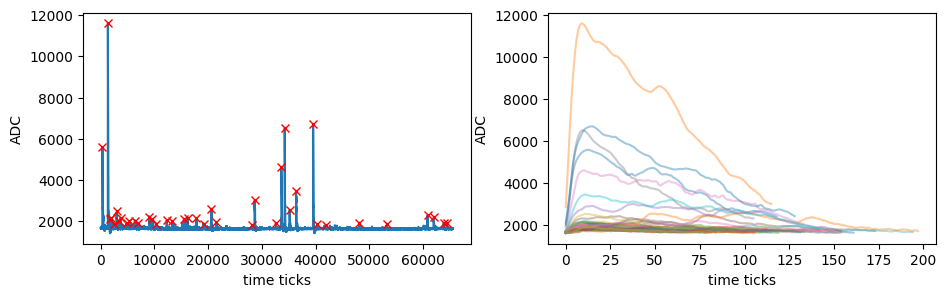

In [13]:
chID = 0
strigRec = 43
peak_indices = peaks[f'ch{chID}']['peak_indices'][trigRec]
waveform = raw_wfs[trigRec, chID]



fig, axs = plt.subplots(1, 2, figsize=(11, 3))
ax = axs[0]
ax.plot(waveform, label="Trigger Record")
ax.plot(peak_indices, waveform[peak_indices], "rx", label="Peaks")
ax.set_xlabel('time ticks')
ax.set_ylabel('ADC')

ax = axs[1]
for pulse in peaks[f'ch{chID}']['pulses'][trigRec]:
    ax.plot( pulse, alpha=0.4 );
ax.set_xlabel('time ticks')
ax.set_ylabel('ADC');